# Building Award-Specific Modeling Datasets

This notebook derives **award-specific datasets** from a shared feature space.

Using:
- `df_clean` for eligibility rules and target construction,
- `X_df_era` / `X_df_modern` for model-ready features,

we create clean, time-aware datasets for each NBA award.

Each award dataset includes:
- an explicitly defined eligible player population,
- a binary winner target,
- consistent train / validation / test splits by season.

Feature definitions are **not modified** in this notebook.
All award logic is applied on top of a fixed, leakage-safe feature space,
ensuring comparability across models and awards.


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

# ------------------------------------------------------------------
# Project root (robust, no pyproject.toml needed)
# Looks for common "project markers": .git, data/, notebooks/, README.md
# ------------------------------------------------------------------

NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR

MARKERS = [
    ".git",
    "data",
    "notebooks",
    "README.md",
]

def is_project_root(p: Path) -> bool:
    return any((p / m).exists() for m in MARKERS)

while not is_project_root(PROJECT_ROOT):
    if PROJECT_ROOT.parent == PROJECT_ROOT:
        raise RuntimeError(
            "Project root not found. Run this notebook from inside the repo "
            "(a folder containing one of: .git, data/, notebooks/, README.md)."
        )
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
DATA_PROCESSED_FINAL = DATA_PROCESSED / "players" / "final"
DATA_INTERIM = PROJECT_ROOT / "data" / "interim"
DATA_INTERIM.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_PROCESSED:", DATA_PROCESSED)


PROJECT_ROOT: C:\Users\Luc\Documents\projets-data\nba-awards-predictor
DATA_PROCESSED: C:\Users\Luc\Documents\projets-data\nba-awards-predictor\data\processed


In [2]:
# Load artifacts
df_clean = pd.read_parquet(DATA_INTERIM / "df_clean.parquet")
X_df_era = pd.read_parquet(DATA_INTERIM / "X_df_era.parquet")
X_df_modern = pd.read_parquet(DATA_INTERIM / "X_df_modern.parquet")

print("df_clean:", df_clean.shape)
print("X_df_era:", X_df_era.shape)
print("X_df_modern:", X_df_modern.shape)


df_clean: (14411, 427)
X_df_era: (14411, 144)
X_df_modern: (14411, 144)


## Helpers


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def time_split_masks(
    df: pd.DataFrame,
    season_col: str = "season",
    train_end: int = 2018,
    val_end: int = 2021,
):
    """
    Time-aware split masks (award-local):
      - Train: season <= train_end
      - Val:   train_end < season <= val_end
      - Test:  season > val_end
    """
    train_mask = df[season_col] <= train_end
    val_mask   = (df[season_col] > train_end) & (df[season_col] <= val_end)
    test_mask  = df[season_col] > val_end
    return train_mask, val_mask, test_mask


def sanity_label_by_split(y: pd.Series, seasons: pd.Series, train_mask: pd.Series, val_mask: pd.Series, test_mask: pd.Series, title: str):
    """Basic sanity checks for extreme-imbalance award labels.

    Prints:
    - class distribution per split (count + ratio)
    - season span per split
    - winners-per-season stats (should be ~1 for most awards)
    Also plots the positive rate for a quick visual check.
    """
    print(f"=== {title} label distribution by split ===")
    for name, mask in [("Train", train_mask), ("Validation", val_mask), ("Test", test_mask)]:
        yy = y.loc[mask]
        vc = yy.value_counts().sort_index()
        total = len(yy)

        out = pd.DataFrame({
            "count": vc,
            "ratio": (vc / total).round(6),
        })
        display(out)

        smin, smax = int(seasons.loc[mask].min()), int(seasons.loc[mask].max())
        print(f"Seasons: {smin} → {smax}")

        winners = yy.groupby(seasons.loc[mask]).sum()
        print(
            f"{name} - winners per season (min/median/max):",
            int(winners.min()),
            float(winners.median()),
            int(winners.max()),
        )
        print()

    rates = [y.loc[train_mask].mean(), y.loc[val_mask].mean(), y.loc[test_mask].mean()]
    plt.figure()
    plt.bar(["Train", "Val", "Test"], rates)
    plt.title(f"{title} positive rate by split")
    plt.ylabel("Winner rate")
    plt.show()


def build_award_dataset(
    df_clean: pd.DataFrame,
    X_df: pd.DataFrame,
    eligibility_mask: pd.Series,
    target_col: str,
):
    """
    Build award dataset:
      - filters df_clean by eligibility_mask
      - builds y from target_col (int8)
      - aligns X from X_df using the filtered df index
    """
    eligibility_mask = eligibility_mask.reindex(df_clean.index).fillna(False)

    df_aw = df_clean.loc[eligibility_mask].copy()
    if target_col not in df_aw.columns:
        raise KeyError(f"Missing target column in df_clean: {target_col}")

    # safe conversion: treat missing as 0 (non-winner)
    y = df_aw[target_col].fillna(0).astype("int8")

    X = X_df.loc[df_aw.index].copy()
    assert len(X) == len(y), "X/y length mismatch after index alignment"
    return df_aw, X, y


In [4]:
# -----------------------------
# MIP helpers (delta YoY dataset)
# -----------------------------

def _infer_player_id_col(df: pd.DataFrame) -> str:
    candidates = ["player_id", "player_key", "player", "Player", "player_name", "name"]
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(
        "Could not infer player identifier column. "
        "Add your column name to candidates in _infer_player_id_col()."
    )

def build_mip_dataset(
    df_clean: pd.DataFrame,
    X_df: pd.DataFrame,
    target_col: str = "is_mip_winner",
    season_col: str = "season",
    rookie_col: str = "is_rookie",
    min_games_curr: int = 20,
    min_games_prev: int = 20,
    drop_pos_dummies: bool = True,
):
    """
    Build MIP dataset: for each (player, season N), features are YoY deltas:
        delta_feature = feature(N) - feature(N-1)

    Eligibility (pre-model):
      - has previous season row (N-1)
      - not a rookie
      - minimum games thresholds on both seasons

    Returns:
      mip_df, X_delta, y_mip
    """
    # --- checks
    if season_col not in df_clean.columns:
        raise KeyError(f"df_clean must contain '{season_col}'")
    if rookie_col not in df_clean.columns:
        raise KeyError(f"df_clean must contain '{rookie_col}'")
    if "G" not in df_clean.columns:
        raise KeyError("df_clean must contain 'G' for games-based filters")
    if target_col not in df_clean.columns:
        raise KeyError(
            f"Missing target column in df_clean: {target_col}. "
            "Ensure it is created in 02_build_df_clean.ipynb."
        )

    player_col = _infer_player_id_col(df_clean)

    # --- IMPORTANT: assumes X_df is row-aligned with df_clean by index
    # If this is not true in your project, we'll adapt (key-based alignment),
    # but your CSV headers suggest X_df is a pure matrix (pct_*) and should match df_clean order.
    if not df_clean.index.isin(X_df.index).all():
        raise ValueError(
            "X_df is not aligned to df_clean by index. "
            "Please ensure X_df keeps df_clean index (recommended), "
            "or share a parquet snippet so we can implement key-based alignment."
        )
    X_aligned = X_df.loc[df_clean.index].copy()

    # --- map previous season index
    cur_keys = df_clean[[player_col, season_col]].copy()

    prev_keys = df_clean[[player_col, season_col]].copy()
    prev_keys[season_col] = prev_keys[season_col] + 1
    prev_keys["prev_idx"] = prev_keys.index

    link = cur_keys.merge(
        prev_keys[[player_col, season_col, "prev_idx"]],
        on=[player_col, season_col],
        how="left",
        validate="1:1",
    )
    prev_idx = link["prev_idx"]

    has_prev = prev_idx.notna()
    not_rookie = ~df_clean[rookie_col].fillna(0).astype(int).eq(1)

    # prev games
    prev_G = pd.Series(np.nan, index=df_clean.index, dtype="float")
    prev_G.loc[has_prev] = df_clean.loc[prev_idx[has_prev].astype(int), "G"].to_numpy()

    meets_games = (df_clean["G"].fillna(0) >= min_games_curr) & (prev_G.fillna(0) >= min_games_prev)

    mip_mask = (has_prev & not_rookie & meets_games).fillna(False)

    mip_df = df_clean.loc[mip_mask].copy()
    y_mip = mip_df[target_col].fillna(0).astype("int8")

    # --- build delta features (row-by-row)
    X_cur = X_aligned.loc[mip_df.index].copy()
    prev_indices = prev_idx.loc[mip_df.index].astype(int)
    X_prev = X_aligned.loc[prev_indices].copy()

    # columns to delta
    delta_cols = list(X_cur.columns)
    if drop_pos_dummies:
        delta_cols = [c for c in delta_cols if not (c.startswith("Pos_") or c.startswith("pos_") or c == "Pos")]

    numeric_cols = [c for c in delta_cols if pd.api.types.is_numeric_dtype(X_cur[c])]
    if not numeric_cols:
        raise ValueError("No numeric columns found to delta in X_df after filtering.")

    # force row-by-row alignment (no pandas index union)
    X_delta = pd.DataFrame(
        X_cur[numeric_cols].to_numpy() - X_prev[numeric_cols].to_numpy(),
        index=mip_df.index,
        columns=[f"delta_{c}" for c in numeric_cols],
    )

    # audit columns (kept in mip_df only)
    mip_df["prev_idx"] = prev_indices.values
    mip_df["prev_G"] = prev_G.loc[mip_df.index].values
    mip_df["mip_has_prev_season"] = True

    # final checks
    assert len(mip_df) == len(X_delta) == len(y_mip), "MIP X/y/df length mismatch"

    return mip_df, X_delta, y_mip


For each NBA award:
- eligibility rules are applied **before modeling**
- the target variable is defined explicitly
- temporal splits are enforced
- strict sanity checks are performed (e.g. one winner per season)

Each resulting dataset is ready to be used in the modeling pipeline.


NBA 65-game rule (introduced in 2023–2024) is **not applied during training**.
It will be enforced only at inference time when selecting the final winner for post-2023 seasons.

## Rookie of the Year (ROY)

The Rookie of the Year award is restricted to first-year NBA players.

Eligibility rules:
- player must be a rookie in the given season

The modeling task consists in ranking rookies within each season to identify the award winner.


ROY population shape: (2422, 427)
Unique seasons (ROY): 1996 → 2025


is_roy_winner
non-winner    2391
winner          31
Name: count, dtype: int64

=== ROY label distribution by split ===


,count,ratio
is_roy_winner,,
0,1665,0.98579
1,24,0.01421


Seasons: 1996 → 2018
Train - winners per season (min/median/max): 1 1.0 2



,count,ratio
is_roy_winner,,
0,314,0.990536
1,3,0.009464


Seasons: 2019 → 2021
Validation - winners per season (min/median/max): 1 1.0 1



,count,ratio
is_roy_winner,,
0,412,0.990385
1,4,0.009615


Seasons: 2022 → 2025
Test - winners per season (min/median/max): 1 1.0 1



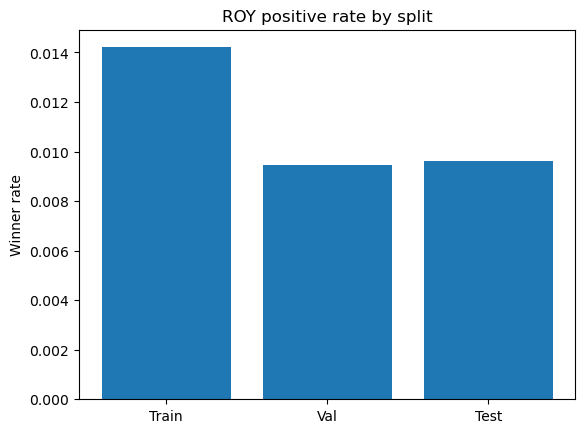

In [5]:
roy_mask = df_clean["is_rookie"].eq(1)

roy_df, X_roy, y_roy = build_award_dataset(
    df_clean=df_clean,
    X_df=X_df_era,
    eligibility_mask=roy_mask,
    target_col="is_roy_winner",
)

print("ROY population shape:", roy_df.shape)
print("Unique seasons (ROY):", int(roy_df["season"].min()), "→", int(roy_df["season"].max()))
display(y_roy.value_counts().rename({0:"non-winner", 1:"winner"}))

train_mask, val_mask, test_mask = time_split_masks(roy_df)
sanity_label_by_split(
    y_roy,
    roy_df["season"],
    train_mask,
    val_mask,
    test_mask,
    "ROY",
)


## Sixth Man of the Year (SMOY)

The Sixth Man of the Year award targets players who primarily contribute off the bench.

Eligibility rules:
- games started (GS) must be strictly lower than games played (G)
- player is not considered a regular starter

The dataset includes only eligible bench players and is modeled as a season-level ranking task.


SMOY population shape: (9346, 427)
Unique seasons (SMOY): 1996 → 2025


is_smoy_winner
non-winner    9316
winner          30
Name: count, dtype: int64

GS <= G-GS rate: 0.6485323711054056
Bench share (min/median/max): 0.0 0.7948717948717948 1.0
=== SMOY label distribution by split ===


,count,ratio
is_smoy_winner,,
0,6686,0.996572
1,23,0.003428


Seasons: 1996 → 2018
Train - winners per season (min/median/max): 1 1.0 1



,count,ratio
is_smoy_winner,,
0,1062,0.997183
1,3,0.002817


Seasons: 2019 → 2021
Validation - winners per season (min/median/max): 1 1.0 1



,count,ratio
is_smoy_winner,,
0,1568,0.997455
1,4,0.002545


Seasons: 2022 → 2025
Test - winners per season (min/median/max): 1 1.0 1



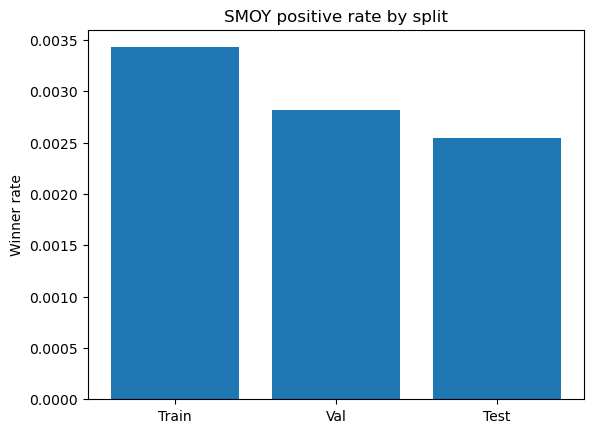

In [6]:
# Eligibility: bench games >= starts
G = df_clean["G"]
GS = df_clean["GS"]
smoy_mask = (GS <= (G - GS))

smoy_df, X_smoy, y_smoy = build_award_dataset(
    df_clean=df_clean,
    X_df=X_df_era,
    eligibility_mask=smoy_mask,
    target_col="is_smoy_winner",
)

print("SMOY population shape:", smoy_df.shape)
print("Unique seasons (SMOY):", int(smoy_df["season"].min()), "→", int(smoy_df["season"].max()))
display(y_smoy.value_counts().rename({0:"non-winner", 1:"winner"}))

# eligibility sanity
bench_share = (G - GS) / G.replace(0, np.nan)
print("GS <= G-GS rate:", float(smoy_mask.mean()))
print("Bench share (min/median/max):", float(bench_share.min()), float(bench_share.median()), float(bench_share.max()))

train_mask, val_mask, test_mask = time_split_masks(smoy_df)
sanity_label_by_split(
    y_smoy,
    smoy_df["season"],
    train_mask,
    val_mask,
    test_mask,
    "SMOY",
)


## Defensive Player of the Year (DPOY)

The Defensive Player of the Year award is open to all eligible players and focuses on defensive impact.

No positional or role-based eligibility filters are applied beyond standard participation constraints.

The modeling task ranks all eligible players within each season.


=== DPOY label distribution by split ===


,count,ratio
is_dpoy_winner,,
0,10504,0.997815
1,23,0.002185


Seasons: 1996 → 2018
Train - winners per season (min/median/max): 1 1.0 1



,count,ratio
is_dpoy_winner,,
0,1596,0.998124
1,3,0.001876


Seasons: 2019 → 2021
Validation - winners per season (min/median/max): 1 1.0 1



,count,ratio
is_dpoy_winner,,
0,2281,0.998249
1,4,0.001751


Seasons: 2022 → 2025
Test - winners per season (min/median/max): 1 1.0 1



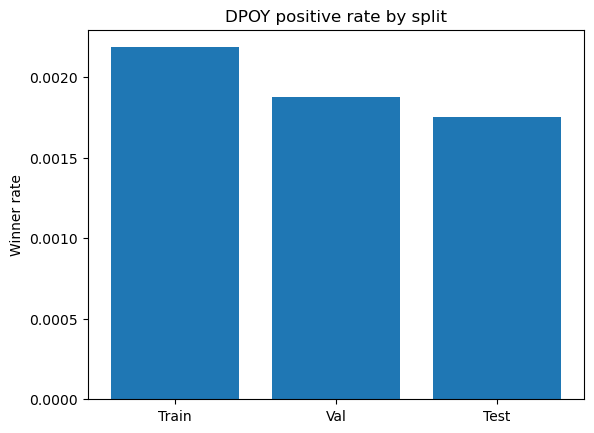

In [7]:
dpoy_mask = pd.Series(True, index=df_clean.index)

dpoy_df, X_dpoy, y_dpoy = build_award_dataset(
    df_clean=df_clean,
    X_df=X_df_era,
    eligibility_mask=dpoy_mask,
    target_col="is_dpoy_winner",
)

train_mask, val_mask, test_mask = time_split_masks(dpoy_df)
sanity_label_by_split(
    y_dpoy,
    dpoy_df["season"],
    train_mask,
    val_mask,
    test_mask,
    "DPOY",
)

## Most Valuable Player (MVP)

The Most Valuable Player award is open to the full player population.

This award is characterized by:
- extreme class imbalance
- strong season-level competition
- high sensitivity to contextual performance

The modeling task is formulated as a season-level ranking problem.


=== MVP label distribution by split ===


,count,ratio
is_mvp_winner,,
0,10504,0.997815
1,23,0.002185


Seasons: 1996 → 2018
Train - winners per season (min/median/max): 1 1.0 1



,count,ratio
is_mvp_winner,,
0,1596,0.998124
1,3,0.001876


Seasons: 2019 → 2021
Validation - winners per season (min/median/max): 1 1.0 1



,count,ratio
is_mvp_winner,,
0,2281,0.998249
1,4,0.001751


Seasons: 2022 → 2025
Test - winners per season (min/median/max): 1 1.0 1



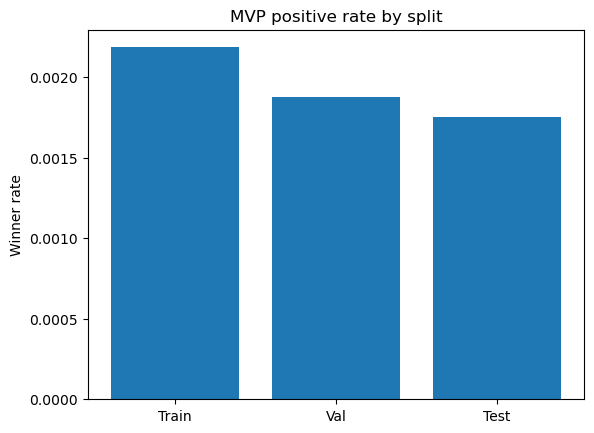

In [8]:
mvp_mask = pd.Series(True, index=df_clean.index)

mvp_df, X_mvp, y_mvp = build_award_dataset(
    df_clean=df_clean,
    X_df=X_df_era,
    eligibility_mask=mvp_mask,
    target_col="is_mvp_winner",
)

train_mask, val_mask, test_mask = time_split_masks(mvp_df)
sanity_label_by_split(
    y_mvp,
    mvp_df["season"],
    train_mask,
    val_mask,
    test_mask,
    "MVP",
)

## Most Improved Player (MIP)

The MIP is *change-based*: it rewards the player with the strongest **year-over-year improvement**.

Therefore, unlike other awards, we build a **dedicated dataset** where the feature space is transformed:
- for each `(player, season N)`, we replace features by their **YoY deltas** vs season `N-1`
- the model ranks players based on **improvement**, not absolute current-season level


Eligibility (pre-model):
- player must have a valid previous season (N−1)
- rookies are excluded
- minimum participation is enforced on both seasons (games threshold)


MIP population shape: (9317, 430)
Seasons: 1997 → 2025


is_mip_winner
0    9289
1      28
Name: count, dtype: int64

=== MIP label distribution by split ===


,count,ratio
is_mip_winner,,
0,6881,0.996957
1,21,0.003043


Seasons: 1997 → 2018


Train - winners per season (min/median/max): 0 1.0 1



,count,ratio
is_mip_winner,,
0,987,0.99697
1,3,0.00303


Seasons: 2019 → 2021
Validation - winners per season (min/median/max): 1 1.0 1



,count,ratio
is_mip_winner,,
0,1421,0.997193
1,4,0.002807


Seasons: 2022 → 2025
Test - winners per season (min/median/max): 1 1.0 1



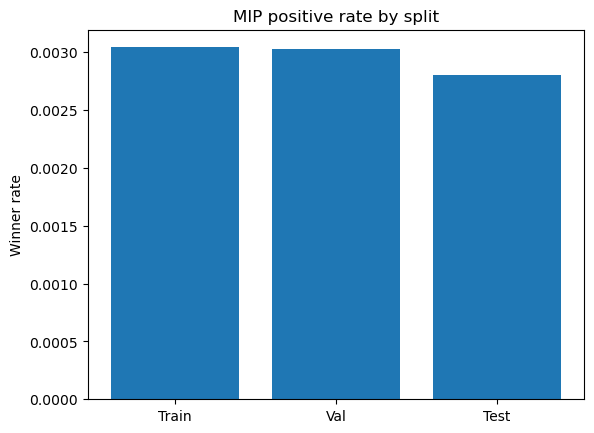

In [9]:
# -----------------------------
# Build MIP dataset (delta YoY)
# -----------------------------

mip_df, X_mip, y_mip = build_mip_dataset(
    df_clean=df_clean,
    X_df=X_df_era,
    target_col="is_mip_winner",
    min_games_curr=20,
    min_games_prev=20,
    drop_pos_dummies=True,
)

print("MIP population shape:", mip_df.shape)
print("Seasons:", int(mip_df["season"].min()), "→", int(mip_df["season"].max()))
display(y_mip.value_counts())

# Split + label sanity
train_mask, val_mask, test_mask = time_split_masks(mip_df)
sanity_label_by_split(
    y_mip,
    mip_df["season"],
    train_mask,
    val_mask,
    test_mask,
    "MIP",
)


In [10]:
w = y_mip.groupby(mip_df["season"]).sum()
seasons_zero = w[w == 0].sort_index()
seasons_zero


season
1997    0
Name: is_mip_winner, dtype: int8

In [11]:
# Drop seasons with no MIP winner in the filtered population
w = y_mip.groupby(mip_df["season"]).sum()
valid_seasons = w[w == 1].index

mask_valid = mip_df["season"].isin(valid_seasons)

print(f"Dropping {len(w[w == 0])} seasons with no eligible MIP winner")

mip_df = mip_df.loc[mask_valid].copy()
X_mip  = X_mip.loc[mip_df.index].copy()
y_mip  = y_mip.loc[mip_df.index].copy()


Dropping 1 seasons with no eligible MIP winner


The 1996–97 season is excluded from the MIP dataset as no prior season is available to compute year-over-year deltas.

## Dataset export

This final step persists all award-specific datasets to disk.

Each award is exported as a triplet:
- the filtered player-season dataframe (audit / metadata)
- the feature matrix used for modeling
- the target vector

These datasets serve as the only inputs to the modeling pipeline (`05_modeling_pipeline.ipynb`).


In [12]:
# Project root (assumes notebooks/ is one level below project root)
PROJECT_ROOT = Path.cwd().parents[0]

BASE_OUT = PROJECT_ROOT / "data" / "interim" / "awards"
BASE_OUT.mkdir(parents=True, exist_ok=True)

def export_award_dataset(award_name, df_award, X_award, y_award, target_col):
    out_dir = BASE_OUT / award_name
    out_dir.mkdir(parents=True, exist_ok=True)

    df_award.to_parquet(out_dir / f"{award_name}_df.parquet")
    X_award.to_parquet(out_dir / f"X_{award_name}.parquet")
    y_award.to_frame(target_col).to_parquet(out_dir / f"y_{award_name}.parquet")

    print(f"[OK] {award_name.upper()} exported to {out_dir}")

# -----------------------------
# Export all award datasets
# -----------------------------

export_award_dataset("roy",  roy_df,  X_roy,  y_roy,  "is_roy_winner")
export_award_dataset("smoy", smoy_df, X_smoy, y_smoy, "is_smoy_winner")
export_award_dataset("dpoy", dpoy_df, X_dpoy, y_dpoy, "is_dpoy_winner")
export_award_dataset("mvp",  mvp_df,  X_mvp,  y_mvp,  "is_mvp_winner")
export_award_dataset("mip",  mip_df,  X_mip,  y_mip,  "is_mip_winner")


[OK] ROY exported to C:\Users\Luc\Documents\projets-data\nba-awards-predictor\data\interim\awards\roy


[OK] SMOY exported to C:\Users\Luc\Documents\projets-data\nba-awards-predictor\data\interim\awards\smoy


[OK] DPOY exported to C:\Users\Luc\Documents\projets-data\nba-awards-predictor\data\interim\awards\dpoy


[OK] MVP exported to C:\Users\Luc\Documents\projets-data\nba-awards-predictor\data\interim\awards\mvp


[OK] MIP exported to C:\Users\Luc\Documents\projets-data\nba-awards-predictor\data\interim\awards\mip


In [13]:
BASE_AUDIT = Path.cwd().parents[0] / "data" / "interim" / "awards"

def audit_award_parquet(award_name, target_col):
    base = BASE_AUDIT / award_name

    df = pd.read_parquet(base / f"{award_name}_df.parquet")
    X  = pd.read_parquet(base / f"X_{award_name}.parquet")
    y  = pd.read_parquet(base / f"y_{award_name}.parquet")[target_col]

    print(f"\n=== AUDIT {award_name.upper()} ===")
    print("df shape:", df.shape)
    print("X  shape:", X.shape)
    print("y  shape:", y.shape)

    assert len(df) == len(X) == len(y), "Length mismatch after export"
    assert df.index.equals(X.index), "Index mismatch df vs X"
    assert df.index.equals(y.index), "Index mismatch df vs y"

    winners_by_season = y.groupby(df["season"]).sum()
    print("Winners per season (min/median/max):",
          int(winners_by_season.min()),
          int(winners_by_season.median()),
          int(winners_by_season.max()))

    print("[OK] Audit passed")

# Run audits
audit_award_parquet("roy",  "is_roy_winner")
audit_award_parquet("smoy", "is_smoy_winner")
audit_award_parquet("dpoy", "is_dpoy_winner")
audit_award_parquet("mvp",  "is_mvp_winner")
audit_award_parquet("mip",  "is_mip_winner")



=== AUDIT ROY ===
df shape: (2422, 427)
X  shape: (2422, 144)
y  shape: (2422,)
Winners per season (min/median/max): 1 1 2
[OK] Audit passed



=== AUDIT SMOY ===
df shape: (9346, 427)
X  shape: (9346, 144)
y  shape: (9346,)
Winners per season (min/median/max): 1 1 1
[OK] Audit passed



=== AUDIT DPOY ===
df shape: (14411, 427)
X  shape: (14411, 144)
y  shape: (14411,)
Winners per season (min/median/max): 1 1 1
[OK] Audit passed



=== AUDIT MVP ===
df shape: (14411, 427)
X  shape: (14411, 144)
y  shape: (14411,)
Winners per season (min/median/max): 1 1 1
[OK] Audit passed



=== AUDIT MIP ===
df shape: (9026, 430)
X  shape: (9026, 144)
y  shape: (9026,)
Winners per season (min/median/max): 1 1 1
[OK] Audit passed


### Parquet-level dataset audit

After exporting all award-specific datasets, a final audit is performed by reloading the
parquet files from disk and validating a set of strict invariants.

For each award, the following conditions are checked:
- the player-season dataframe, feature matrix, and target vector have identical lengths,
- indices are perfectly aligned across `df`, `X`, and `y`,
- exactly one award winner is present per season (after eligibility filtering).

This audit ensures that the exported datasets are self-consistent, reproducible, and can be
safely consumed by the modeling pipeline without re-running upstream notebooks.
